## <u>CNN for image classification</u>

This model is a benchmark model meant to provide a benchmark score for the final model. The key metric for this model will be its F1 score.

In [ ]:
# import modules
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras import backend as K

# create CNN architecture
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 5, activation = 'softmax'))

model.summary()

# source/credit : https://www.kaggle.com/arsenyinfo/f-beta-score-for-keras
# code for calculating the F1 metric
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    y_pred = K.clip(y_pred, 0, 1)
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

## <u>Image generator and training.</u>

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# define parameters
batch_size=20
image_size=(150, 150)
epochs=30

# create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

training_generator = train_datagen.flow_from_directory(
    'diabetic/processed_images/train',
    target_size=image_size,
    classes=['0', '1', '2', '3', '4'],
    batch_size=20,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'diabetic/processed_images/validation',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

# compile the model and train
model.compile(
    optimizer=RMSprop(lr=1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['acc', fbeta])

history = model.fit_generator(
        training_generator,
        steps_per_epoch=500,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps=100)

Found 30000 images belonging to 5 classes.
Found 5120 images belonging to 5 classes.
Epoch 1/30
500/500 [==============================] - 118s - loss: 0.8944 - acc: 0.7353 - fbeta: 0.7282 - val_loss: 0.8332 - val_acc: 0.7440 - val_fbeta: 0.7440
Epoch 2/30
500/500 [==============================] - 119s - loss: 0.9003 - acc: 0.7327 - fbeta: 0.7288 - val_loss: 0.8288 - val_acc: 0.7545 - val_fbeta: 0.7545
Epoch 3/30
500/500 [==============================] - 114s - loss: 0.9091 - acc: 0.7298 - fbeta: 0.7251 - val_loss: 0.8301 - val_acc: 0.7470 - val_fbeta: 0.7471
Epoch 4/30
500/500 [==============================] - 105s - loss: 0.8925 - acc: 0.7322 - fbeta: 0.7285 - val_loss: 0.8491 - val_acc: 0.7415 - val_fbeta: 0.7408
Epoch 5/30
500/500 [==============================] - 106s - loss: 0.8932 - acc: 0.7329 - fbeta: 0.7304 - val_loss: 0.8218 - val_acc: 0.7530 - val_fbeta: 0.7527
Epoch 6/30
500/500 [==============================] - 105s - loss: 0.8922 - acc: 0.7327 - fbeta: 0.7305 - val_

## <u>Visualizing loss and accuracy</u>

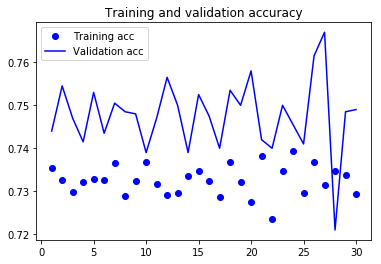

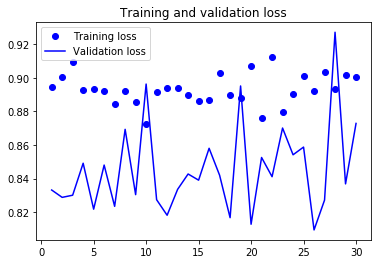

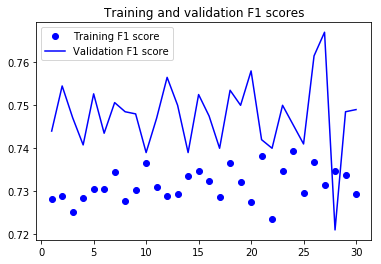

In [11]:
import h5py
import matplotlib.pyplot as plt

# save model and weight for future training
model.save("benchmark_model_cnn.model")
model.save('saved_models/benchmark_model.h5')
model.save_weights('saved_models/benchmark_model_weights.h5', overwrite=True)
json_string = model.to_json()

with open('saved_models/benchmark_model.json', 'w') as f:
      f.write(json_string)

# define variables for plotting
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['fbeta']
val_f1 = history.history['val_fbeta']
epochs = range(1, len(acc) + 1)

# plot graphs for loss, accuracy and F1 score
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, f1, 'bo', label='Training F1 score')
plt.plot(epochs, val_f1, 'b', label='Validation F1 score')
plt.title('Training and validation F1 scores')
plt.legend()
plt.show()


## <u>Run prediction model on subset of testing dataset</u>

The prediction model is run on a small subset to determine its ability to predict the class of each image

In [12]:
# run prediction on testing subset of original dataset (1000 images)
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import os
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

if __name__ == "__main__":
    # load previously saved model and weights
    model.load_weights('saved_models/benchmark_model_weights.h5')    
    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
# Single Image
#     img_path = image.load_img('sample/test2/38016_right.jpeg', target_size=(224, 224))
#     x = image.img_to_array(img_path)
#     x = np.expand_dims(x, axis=0)

#     filenames = sample_generator.filenames
#     nb_samples = len(filenames)
#     print(nb_samples)
#     prediction = model.predict_generator(sample_generator, steps = 17)
#     print prediction
    
    # create test data generators
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
            'diabetic/processed_images/test_subset',
            target_size=(150, 150),
            shuffle = "false",
            class_mode=None,
            batch_size=1)

    filenames = test_generator.filenames
    nb_samples = len(filenames)
    
    predicted_classes = np.argmax(test_generator)
    true_classes = test_generator.classes
    
    # run prediction
    predict = model.predict_generator(test_generator, steps = 1000, verbose=1)
    
    # visualize predicted classes on test subset
    print('\n')
    print(predict.argmax(axis=-1).astype(int))

Found 1000 images belonging to 1 classes.
1000/1000 [==============================] - 80s    


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 

Even with an average validation accuracy of 75%, each image is predicted to belong to class 0 (Normal), when images were **sampled** from classes 0, 1, 2, 3 and 4 of the validation dataset.

Even after adjusting the dataset imbalance, the model is unable to predict the class of a provided retial fundus image.

## <u>Next steps</u>

A model based on InceptionV3 was used by a team at Google to predict Diabetic Retinopathy from fundus images with the accuracy of _95%_.

Source:

* Video (Tensorflow in Medicine) - [link](https://www.youtube.com/watch?v=oOeZ7IgEN4o)
* Journal paper - [link](https://jamanetwork.com/journals/jama/fullarticle/2588763)
* Blog post - [link](https://research.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html)

The InceptionV3 model pre-trained on ImageNet will be loaded into Keras for training and prediction.